# Comparing real and simulated assemblages
## Assessing typicality and deviation from expectations empirically


With domestic assemblages, it is unclear in many cases whether the handful of sherds and other objects are meaningfully deposited rather than reflecting depositional and post-depositional processes. One way of considering this problem is to construct alternative assemblages via bootstrapping and other simulation techniques that let us glimpse larger universes of archaeological sites and compare them to our own.

This code attempts to do so by taking the empirical frequency and density of artifacts separated by categories across multiple assemblages and generating statistically similar assemblages in order to estimate what "typical" assemblages with these properties would look like. These generated assmeblages can be contrasted with individual real assemblages or the set of all observed assemblages to quantify how close the observed archaeological record is to a random categorical distribution.

A quick note about this code: this runs in Python 3, and hasn't been tested in Python 2. It might work! I just haven't checked it yet.

In [1]:
import numpy as np
import scipy
import matplotlib.pyplot as plt
import random as rd
import pandas as pd

from simulate_assemblages import *

In [2]:
#Although not in the source code, let's visualize the results using some nice plots
## this requires sklearn for the pca; you're welcome to not use this 
## and just switch the PCA over to something else
import sklearn.preprocessing
import sklearn.decomposition
from sklearn.pipeline import Pipeline

def plot_results(result):
    """Take the result object from either function and return a nice plot of the distribution."""
    #Create two plots: one a distance histogram, one a PCA scatter plot
    fig, (ax1, ax2) = plt.subplots(1,2, figsize = (10,5))
    fig.suptitle('Simulated assemblages (N = {0})'.format(result['N']))
    
    # First, the histogram of distances
    ax1.hist(result['distance_simulation'], bins = 20)
    ax1.plot([result['distance_observed']]*2, [0,result['N']/5], 'r-')
    mean_dist = result['distance_simulation'].mean()
    ax1.plot([mean_dist]*2, [0,result['N']/5], 'k-')
    ax1.set_title('Distance from center (p = {0})'.format(result['p-value']))
    ax1.set_xlabel('Distance from center of distribution')
    
    #PCA plot: create a 2-d plot of the (large) dimensional distribution array
    collector_flat = result['raw_simulation'].reshape(result['N'], -1)
    data_flat = result['raw_observed'].reshape(1, -1)
    scaler = sklearn.preprocessing.StandardScaler().fit(collector_flat)
    pca = sklearn.decomposition.PCA(n_components = 2)
    pca.fit(scaler.transform(collector_flat))
    workflow = Pipeline(steps = [('scale',scaler),('pca',pca)])
    collector_transformed = workflow.transform(collector_flat)
    observed_transformed = workflow.transform(data_flat)
    mean_transformed = workflow.transform(collector_flat.mean(axis = 0).reshape(1,-1))
    ax2.plot(collector_transformed[:,0], collector_transformed[:,1],'b.', alpha = .15)
    ax2.plot(observed_transformed[:,0], observed_transformed[:,1],'r.', markersize = 10)
    ax2.plot(mean_transformed[:,0], mean_transformed[:,1],'.', color = 'gray', markersize = 10)
    ax2.set_xlabel('Normalized distance in projection')
    ax2.set_title('2-d projection of {0}-d distribution ({1:.0f}% of variance)'.format(collector_flat.shape[1],round(100*sum(workflow['pca'].explained_variance_ratio_),0)))    #pca.explained_variance_ratio_ #note: this should just be used for visualization, NOT for classification

## Example usage

Our example data record the distribution of cooking pot fragments from Terrace House C at Monastiraki Katalimata, East Crete, Greece based on three main parts of the house: the East living quarters ("East House"), the West living quarters ("West House"), and the open-air area to the east ("East Area"). (Nowicki 2008)

In [16]:
dt = {'dish' : [1,0,2],
     'tray' : [1,0,0],
     'pot' : [3,3,1]}
df = pd.DataFrame(data = dt, index = ['East House','West House','East Area'])
df

,dish,tray,pot
East House,1,1,3
West House,0,0,3
East Area,2,0,1


(Note that these are example data, and in practice you would likely want to separate vessels represented by single sherds vs. mendable or largely restorable vessels. The main takeaway is that this method works on any discrete count data.)

In [4]:
r = simulate_assemblages_collection(df, 1000, 2, 'calculated')
r

{'raw_simulation': array([[[1., 1., 7.],
         [1., 0., 1.],
         [0., 0., 0.]],
 
        [[1., 1., 2.],
         [0., 0., 3.],
         [1., 0., 3.]],
 
        [[0., 0., 5.],
         [1., 0., 3.],
         [0., 0., 2.]],
 
        ...,
 
        [[3., 0., 3.],
         [1., 0., 2.],
         [0., 0., 2.]],
 
        [[1., 0., 4.],
         [0., 0., 3.],
         [1., 0., 2.]],
 
        [[2., 1., 2.],
         [0., 0., 5.],
         [0., 0., 1.]]]),
 'raw_observed': array([[1, 1, 3],
        [0, 0, 3],
        [2, 0, 1]], dtype=int64),
 'distance_simulation': array([4.50894428, 2.2489667 , 2.72424074, 2.2489667 , 3.12811828,
        3.76148379, 2.62221911, 2.51606409, 2.55193979, 4.06354484,
        1.94553951, 4.72552415, 1.99171839, 2.85460336, 1.26621712,
        3.78557506, 3.27020105, 2.40522846, 2.20817415, 3.32533476,
        2.28903242, 4.19562937, 2.72424074, 1.74867128, 2.9792672 ,
        1.33608531, 2.51606409, 3.03968245, 2.75740925, 2.91760119,
        2.405228

1000 simulated sites, consisting of three assemblages with three different types of vessels were generated using the empirical frequency and density of objects. Distances from the calculated center of the distribution were recorded as a measure of difference, and can be compared with the difference between the simulated assemblages and the observed assemblages to assess how close to an expected set of assemblages the distribution is. 

The output object, here stored as `r`, includes all generated assemblages, the observed assemblages, calculated distances for both the generated and observed assemblages, the p-value for measuring whether our observed data can be classified as unusually far from the center, and the parameters of the model. We can visualize these using the `plot_results` function defined above.

77.9% of simulated sites were further from the center than the observed assemblages.


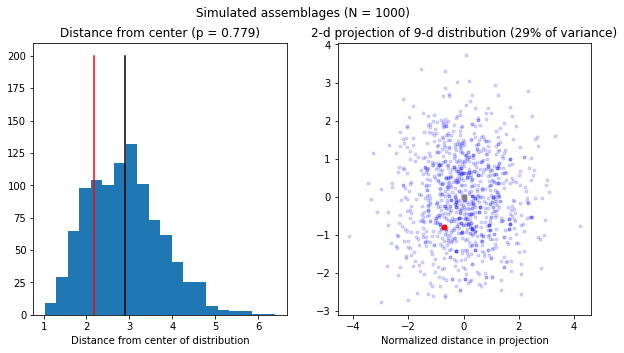

In [5]:
plot_results(r)
print('{0:2.1f}% of simulated sites were further from the center than the observed assemblages.'.format(100*r['p-value']))

Overall, Monastiraki Katalimata is very close to typical, or what we would expect given the density and frequency of objects; it is typically within the closest 20-25% of simulated sites to the mean frequencies or expected distribution. This means that we shouldn't be "surprised" at the distribution of objects across the different assemblages: the frequency and density of artifacts explains the observed distribution pretty well. Whether the frequency of objects is itself meaningful would require comparison with another site.

We can also check a single assemblage against the properties of all assemblages under consideration. This method addresses whether a single assemblage within a larger site may be less typical or may require an explanation greater than random chance. Let's look at the East Area, an outdoor cooking area of Terrace House C.

In [32]:
r = simulate_assemblage_single(df, df.index.get_loc('East Area'), N = 10000, center = 'observed')
r

{'raw_simulation': array([[1., 0., 2.],
        [0., 1., 2.],
        [0., 1., 2.],
        ...,
        [1., 2., 0.],
        [2., 0., 1.],
        [0., 0., 3.]]),
 'raw_observed': array([2, 0, 1], dtype=int64),
 'distance_simulation': array([0.34067929, 1.09839081, 1.09839081, ..., 2.57985705, 1.51507834,
        1.39164018]),
 'distance_observed': 1.5150783412087971,
 'p-value': 0.209,
 'N': 10000,
 'p_dist': 2,
 'center': 'observed'}

Despite the overall house having a close-to-expected distribution of different cooking vessels based on the density and frequency of different types, the East Area itself is somewhat less typical - only ~20% of all simulated assemblages are further from the expected distribution. While this may not be "significant" in a hypothesis testing framework, it is notable.

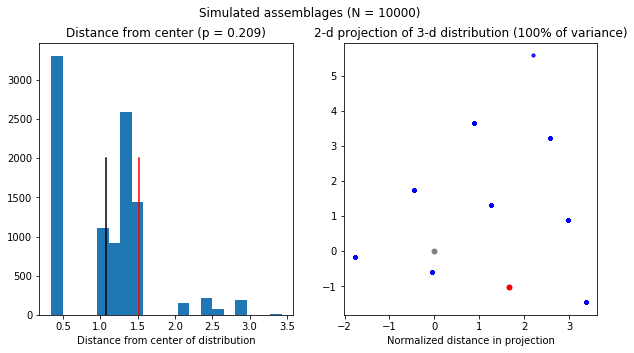

In [34]:
plot_results(r)

The power of such an analysis is the ability to run it across scales and datasets, checking how typicality exists across and within sites.

Finally, these same scores can be calculated for all assemblages in a site, enabling more "typical" or "expected" assemblages to be separated from "atypical" or "surprising" assemblages based on the relative variation between the frequency and density of different categories of objects between assemblages.

In [38]:
#Create a series of the p-values in order
pvs = []
for i in df.index:
    r = simulate_assemblage_single(df, df.index.get_loc(i), N = 10000, center = 'observed')
    pvs.append(r)
p = pd.Series([r['p-value'] for r in pvs], name = 'p-value', index = df.index)
# concatenate the series and sort by p-value so the lowest (and therefore most exceptional) are at the top
df_p = pd.concat((df,p), axis = 1).sort_values('p-value')
df_p

,dish,tray,pot,p-value
East Area,2,0,1,0.2055
West House,0,0,3,0.4617
East House,1,1,3,1.0000


These types of comparisons can easily be applied at scale to entire sites or regions, providing an intuitive, empirical tool for comparing expected and observed distributions of objects across assemblages.

## Bibliography 

Nowicki, Krzysztof. 2008. Monastiraki Katalimata: Excavation of a Cretan Refuge Site, 1993-2000. Prehistory Monographs 24. Philadelphia, PA: INSTAP Academic Press.
